# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import itertools

import nltk
from farasa.stemmer import FarasaStemmer
import gensim
import arabic_reshaper
from bidi.algorithm import get_display

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import emojis
import re

# Read and Clean 

In [2]:
df_train = pd.read_csv(r"data/ArSarcasm_train.csv")
df_test = pd.read_csv(r"data/ArSarcasm_test.csv")

In [3]:
stemmer =  FarasaStemmer(interactive=True)

[2021-06-17 18:38:06,639 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [4]:
def clean_tweet(text):

    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel,"", text)

    search = ["أ", "إ", "آ", "ة", "_", "-", "/", ".", "،", " و ", " يا ", '"', "ـ", "'", "ى",
              "\\", '\n', '\t', '&quot;', '?', '؟', '!']
    replace = ["ا", "ا", "ا", "ه", " ", " ", "", "", "", " و", " يا",
               "", "", "", "ي", "", ' ', ' ', ' ', ' ? ', ' ؟ ', ' ! ']


    text = re.sub("#", ' ', text)
    text = text.replace('_', ' ')
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"[a-zA-Z]", '', text)

    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])

    text_cleaning_re = "@\S+|https?:\S+|http?:\S"
    text = re.sub(text_cleaning_re, ' ', str(text)).strip()

    return text

In [5]:
df_train['cleaned_tweet'] = df_train['tweet'].apply(clean_tweet)
df_test['cleaned_tweet'] = df_test['tweet'].apply(clean_tweet)

In [6]:
df_train['cleaned_tweet'] = df_train['cleaned_tweet'].apply(lambda x: stemmer.stem(x))
df_test['cleaned_tweet'] = df_test['cleaned_tweet'].apply(lambda x: stemmer.stem(x))

In [7]:
df_train.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح ما عمر اتنزل لعب سوبر ماريو مش زي ما كان ...
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجل ماري كلير ملك صحراء
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة لان دمشق صاير موسكو
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد في حرس اعترف فقدان سيطره امنيه في شرقي غر...


In [8]:
df_test.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet
0,msa,True,negative,negative,"""@AbuEmad74241481 @Cesars2014 هههههه حزب الله ...",semeval,هههههه حزب الله حطم اسطور ميركافا اسرائيليه عا...
1,gulf,False,positive,neutral,"""RT @JannetForster: البنات اللي م صامو بقولكم ...",semeval,بنت لي م صامو قول رأى رمضان قرب وقت قليل ف لي ...
2,msa,True,neutral,neutral,اشارة رابعة اشبه بنار تحرق الانقلابيين,astd,اشار رابع أشبه نار أحرق انقلاب
3,msa,False,neutral,neutral,"""@EGYPTAIR ماهي مميزات درجه بزنس علماً اني في ...",semeval,ماهي مميز درج بزنس علم ان في بروكسل اريد ذهاب ...
4,msa,False,neutral,neutral,ما لا تراه على التلفاز منافسة شديدة بين المرشح...,semeval,ما لا رأى علي تلفاز منافس شديد بين مرشح هيلاري...


# Remove stopwords

In [9]:
import arabicstopwords.arabicstopwords as stp

stp.stopwords_list()

dict_keys(['وعداهم', 'جنبنا', 'فباللتين', 'وبماذا', 'وأخونا', 'وكبعضكما', 'وعدانا', 'أفكعيننا', 'فإنهم', 'فإنهن', 'ولنا', 'كغربكن', 'بأنهما', 'أفبنفس', 'فبتلكم', 'أفبكلهما', 'فلشرقها', 'وكبعضنا', 'وبحسبكما', 'عليهما', 'بكلتا', 'أفبهنالك', 'لحسبي', 'أإلينا', 'وكابننا', 'بفينا', 'لحسبك', 'فلشرقهن', 'فلشرقهم', 'فبأخي', 'ولست', 'فلإليه', 'بغير', 'فباللتيا', 'ولكلكما', 'فلشهرهما', 'بأقلنا', 'فإنها', 'فلأخيكما', 'ألعن', 'ألعل', 'أفكبعضكما', 'أوعينكم', 'فكأقل', 'فلنفسهن', 'أوعينكن', 'ولعنهن', 'ولعلينا', 'ولعنهم', 'أفلغيرهم', 'أفلغيرهن', 'ألإنها', 'أخاه', 'ولأقلك', 'أخاي', 'وسويهن', 'ولأثناءي', 'أفلكأنها', 'ولأقلي', 'إلى', 'فلتلقاءها', 'ولغرب', 'ألازلتن', 'وكغيره', 'وكغيرك', 'وليتكن', 'وليتكم', 'وكغيري', 'وعندكم', 'أثناءكم', 'فشطركم', 'فشطركن', 'فلتلقاءهم', 'ومعاذهما', 'فلتلقاءهن', 'أوكعينكما', 'سبحانكما', 'فبجميعك', 'أخوه', 'فبجميعه', 'فلكنكما', 'أخوي', 'فبجميعي', 'لكنما', 'وكحمي', 'فلدنه', 'فكهناك', 'ألأجمعهن', 'أكأجمعي', 'فكهاتين', 'فبنفسكما', 'بشبه', 'حواليكن', 'بتلقاءنا', 'أكأجمعه', 'فأبي

In [10]:
#removing Stop Words function
def remove_stopWords(sentence):
    terms=[]
    stopWords= set(stp.stopwords_list())
    for term in sentence.split() : 
        if term not in stopWords :
            terms.append(term)
    return " ".join(terms)

df_train["cleaned_tweet"] = df_train["cleaned_tweet"].apply(remove_stopWords)
df_test["cleaned_tweet"] = df_test["cleaned_tweet"].apply(remove_stopWords)

In [11]:
df_train.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح عمر اتنزل لعب سوبر ماريو مش زي متوقع الله...
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجل ماري كلير ملك صحراء
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة لان دمشق صاير موسكو
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد حرس اعترف فقدان سيطره امنيه إيران احواز ا...


# Build our Vocab List

In [12]:
vocab = []
for tw in df_train['cleaned_tweet']:
    for word in tw.split():
        if word not in vocab:
            vocab.append(word)

vocab = sorted(vocab)

In [13]:
print(len(vocab))

15198


# Prepare Data to Train

In [14]:
train_data = df_train[['sarcasm', 'cleaned_tweet']]
test_data = df_test[['sarcasm', 'cleaned_tweet']]

In [15]:
train_data['sarcasm'] = train_data['sarcasm'].apply(lambda x: 1 if x==True else 0)
test_data['sarcasm'] = test_data['sarcasm'].apply(lambda x: 1 if x==True else 0)

<ipython-input-15-8cb7745a2a45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sarcasm'] = train_data['sarcasm'].apply(lambda x: 1 if x==True else 0)
<ipython-input-15-8cb7745a2a45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sarcasm'] = test_data['sarcasm'].apply(lambda x: 1 if x==True else 0)


In [16]:
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)
X_train = train_data['cleaned_tweet']
X_test = test_data['cleaned_tweet']
y_train = train_data['sarcasm'].tolist()
y_test = test_data['sarcasm'].tolist()

print('Size of train data: {}'.format(len(X_train)))
print('Size of test data: {}'.format(len(X_test)))
print('Size of train labels: {}'.format(len(y_train)))
print('Size of test labels: {}'.format(len(y_test)))

Size of train data: 8180
Size of test data: 2093
Size of train labels: 8180
Size of test labels: 2093


<ipython-input-16-9b13ab82f2b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(inplace=True)
<ipython-input-16-9b13ab82f2b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(inplace=True)


In [17]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

X_train_tokens = train_data['cleaned_tweet'].apply(tokenizer.tokenize)
X_test_tokens = test_data['cleaned_tweet'].apply(tokenizer.tokenize)

# Evaluation Matrix

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

# Fitting First Classifier (Logistic Regression)

## Train the Model

# 1- Bag of Word

In [19]:
def bow_emb(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


X_train_bow_emb, count_vectorizer = bow_emb(X_train)
X_test_bow_emb = count_vectorizer.transform(X_test)

## Visualize BOW

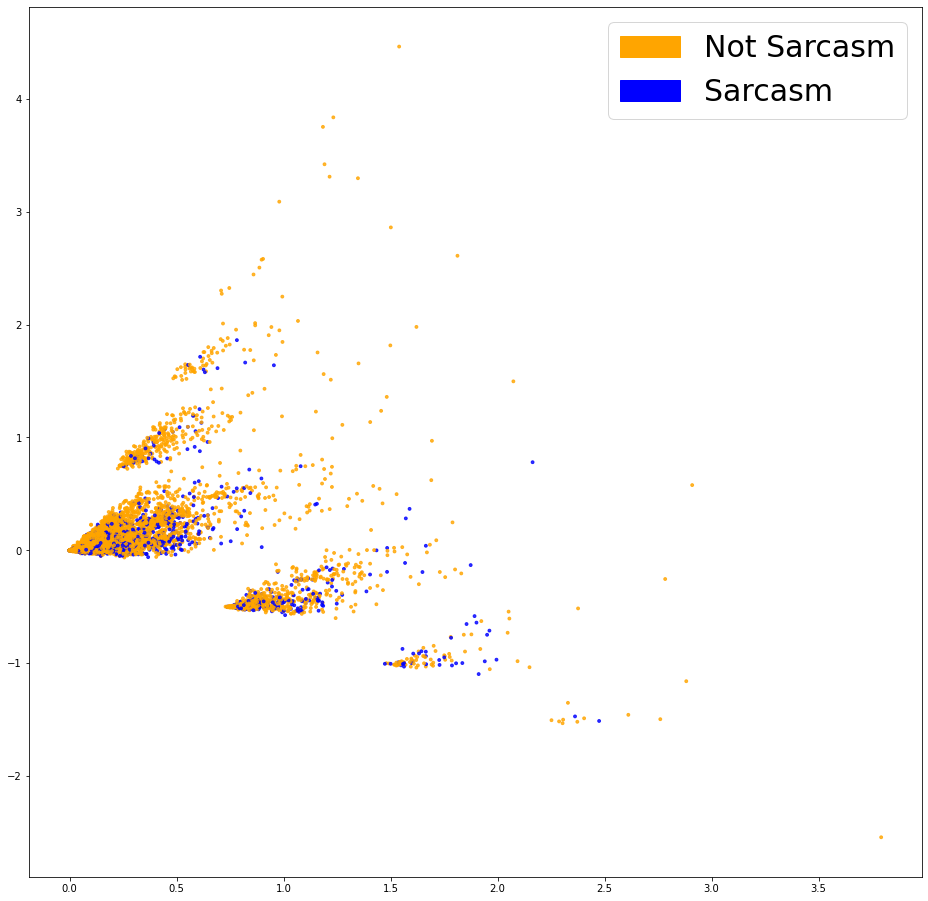

In [20]:
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange', 'blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Not Sarcasm')
            green_patch = mpatches.Patch(color='blue', label='Sarcasm')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_bow_emb, y_train)
plt.show()

In [21]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_bow.fit(X_train_bow_emb, y_train)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)


The f1 score for the testing data: 0.43820224719101125
The precision score for the testing data: 0.42276422764227645
The recall score for the testing data: 0.45481049562682213
The accuracy score for the testing data: 0.8088867654085046


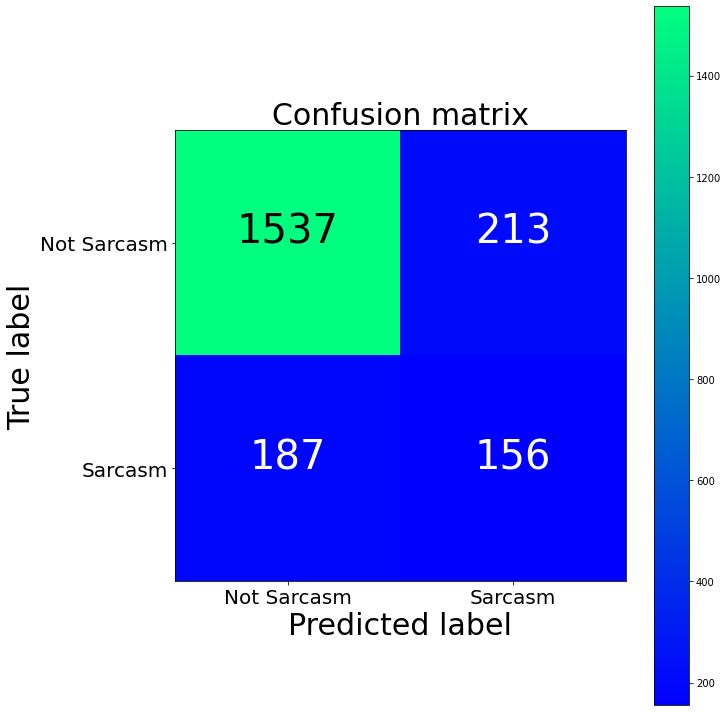

In [22]:
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

## Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

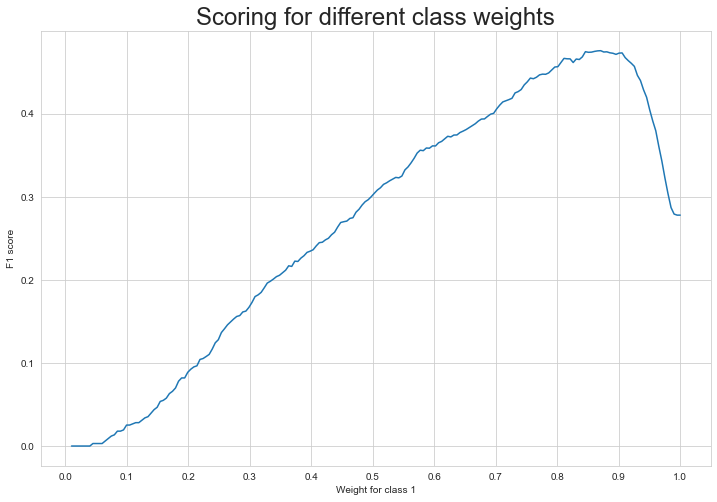

In [23]:
lr_bow = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_bow, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_bow_emb, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [24]:
weight_for_high_score = weigh_data[weigh_data['score'] == np.max(weigh_data.score)]['weight']
weight_for_high_score

26    0.870653
Name: weight, dtype: float64

The f1 score for the testing data: 0.45642201834862384
The precision score for the testing data: 0.3761814744801512
The recall score for the testing data: 0.5801749271137027
The accuracy score for the testing data: 0.7735308170090779


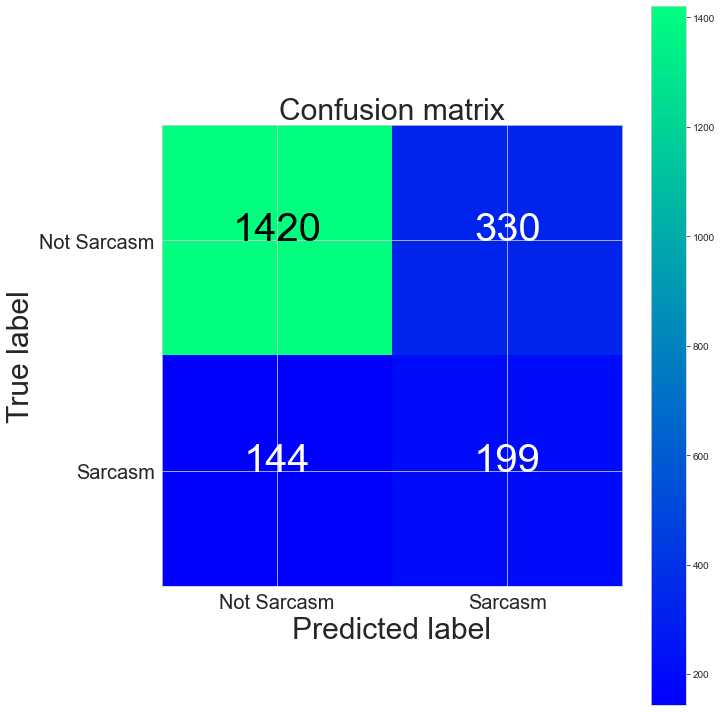

In [25]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
lr_bow.fit(X_train_bow_emb, y_train)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

In [26]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, lr_bow, 10)

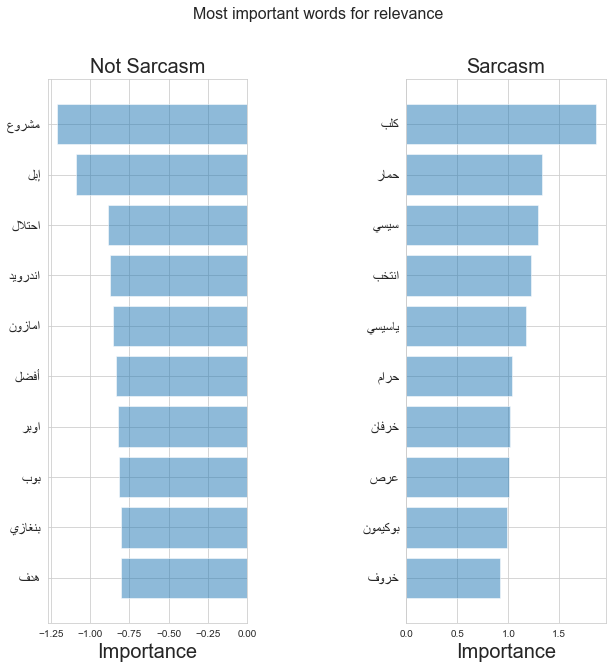

In [27]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    top_words = [get_display(arabic_reshaper.reshape(a[0])) for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    bottom_words = [get_display(arabic_reshaper.reshape(a[0])) for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    fig = plt.figure(figsize=(10, 10))  
    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Not Sarcasm', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Sarcasm', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# 2- TF-IDF

In [28]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)  
    return train, tfidf_vectorizer

X_train_tfidf_emb, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf_emb = tfidf_vectorizer.transform(X_test)

## Visualize TF-IDF

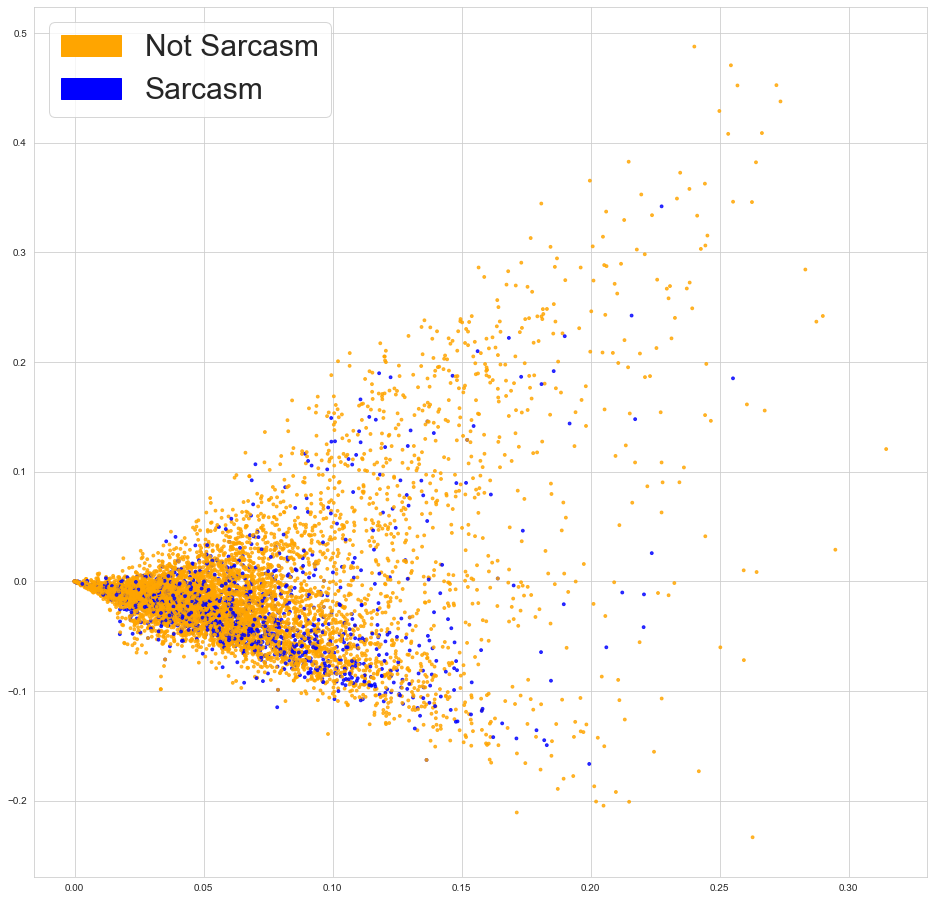

In [29]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf_emb, y_train)
plt.show()

In [30]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_tfidf.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

The f1 score for the testing data: 0.4546525323910483
The precision score for the testing data: 0.3814229249011858
The recall score for the testing data: 0.5626822157434402
The accuracy score for the testing data: 0.7787864309603441


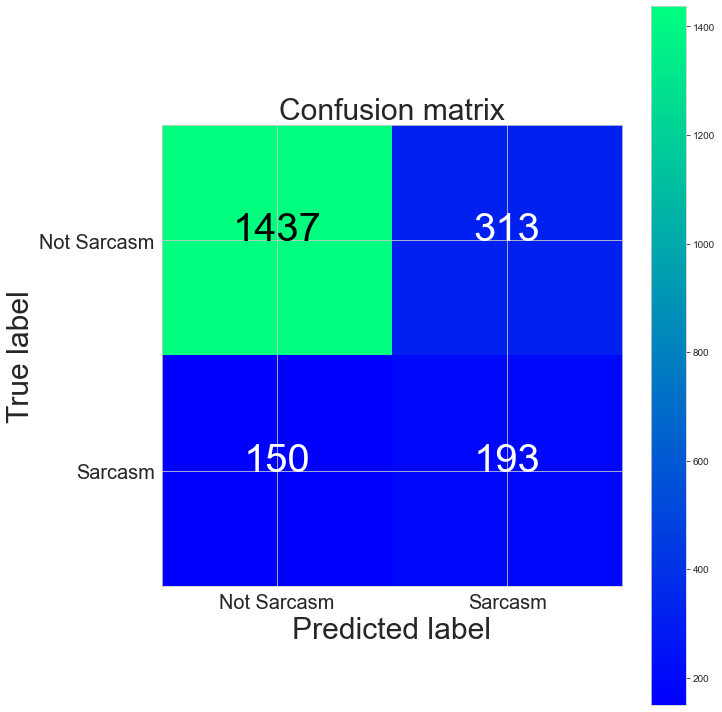

In [31]:
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

## Handel the Imbalace Manually

The f1 score for the testing data: 0.4557988645579886
The precision score for the testing data: 0.31573033707865167
The recall score for the testing data: 0.8192419825072886
The accuracy score for the testing data: 0.6794075489727663


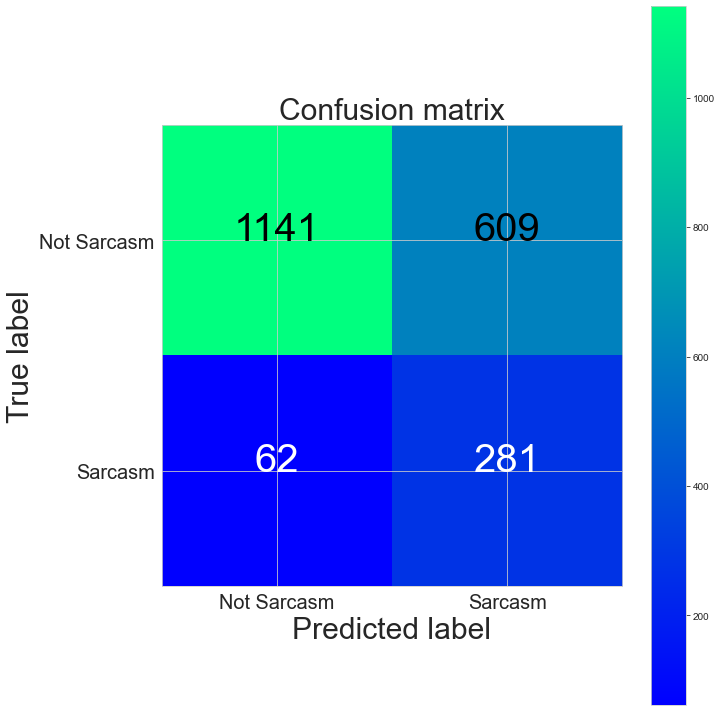

In [32]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
lr_tfidf.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

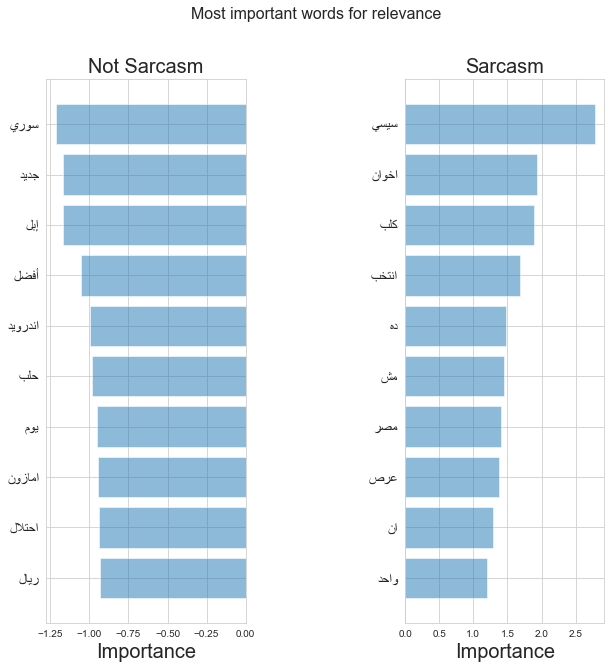

In [33]:
importance = get_most_important_features(tfidf_vectorizer, lr_tfidf, 10)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# 3- Pre-trained Word2Vec Model

In [34]:
LEN_OF_TRAIN_TWEETS = [len(i) for i in X_train]
NUM_TRAIN_WORDS = sum(LEN_OF_TRAIN_TWEETS)
TRAIN_MAX_LEN = max(LEN_OF_TRAIN_TWEETS)

LEN_OF_TEST_TWEETS = [len(i) for i in X_test]
NUM_TEST_WORDS = sum(LEN_OF_TEST_TWEETS)
TEST_MAX_LEN = max(LEN_OF_TEST_TWEETS)

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

train_tokenizer = Tokenizer(nb_words = NUM_TRAIN_WORDS)
train_tokenizer.fit_on_texts(X_train)
train_seq = train_tokenizer.texts_to_sequences(X_train)

test_tokenizer = Tokenizer(nb_words = NUM_TEST_WORDS)
test_tokenizer.fit_on_texts(X_test)
test_seq = test_tokenizer.texts_to_sequences(X_test)

c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [36]:
X_train_padding = pad_sequences(train_seq, maxlen=TRAIN_MAX_LEN, padding='post')
X_test_padding = pad_sequences(test_seq, maxlen=TEST_MAX_LEN, padding='post')

In [37]:
print(X_train_padding.shape)
print(X_test_padding.shape)

(8180, 116)
(2093, 116)


In [38]:
import gensim

word2vec_path = "sg_100.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, unicode_errors='ignore')   

In [39]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [40]:
train_embeddings = get_word2vec_embeddings(model, X_train_tokens)
test_embeddings = get_word2vec_embeddings(model, X_test_tokens)

## Visualize W2V

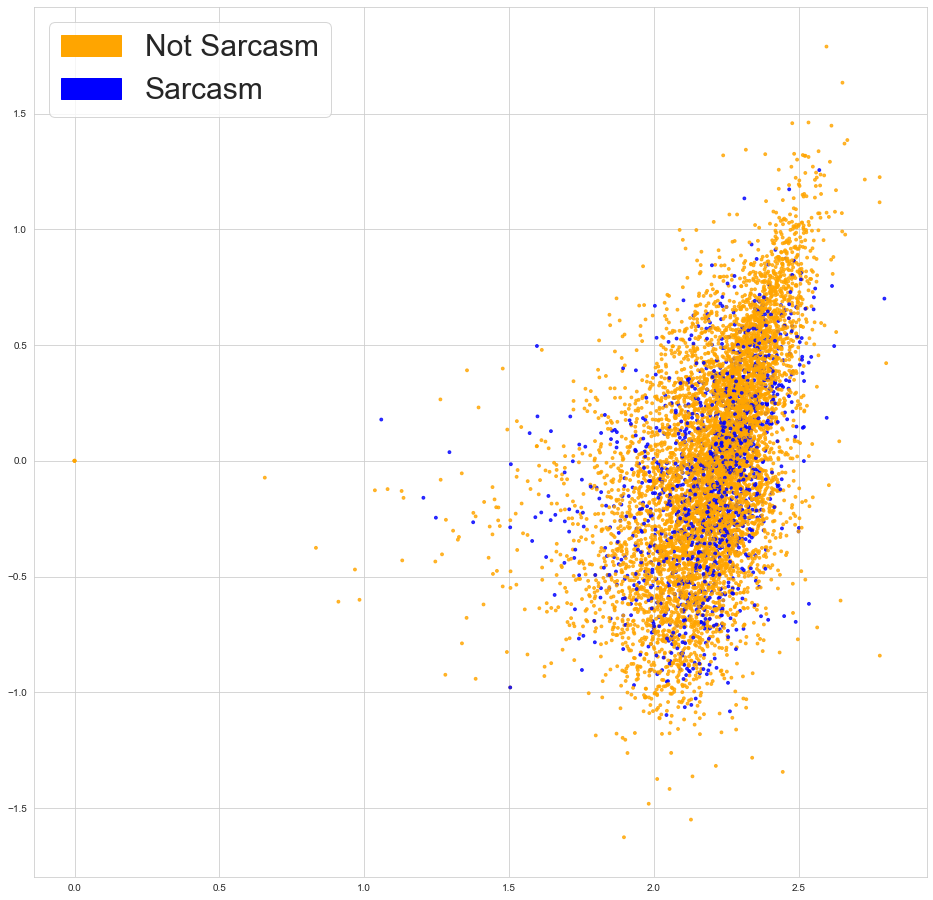

In [41]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(train_embeddings, y_train)
plt.show()

The f1 score for the testing data: 0.4906771344455348
The precision score for the testing data: 0.3698224852071006
The recall score for the testing data: 0.7288629737609329
The accuracy score for the testing data: 0.7520305781175346


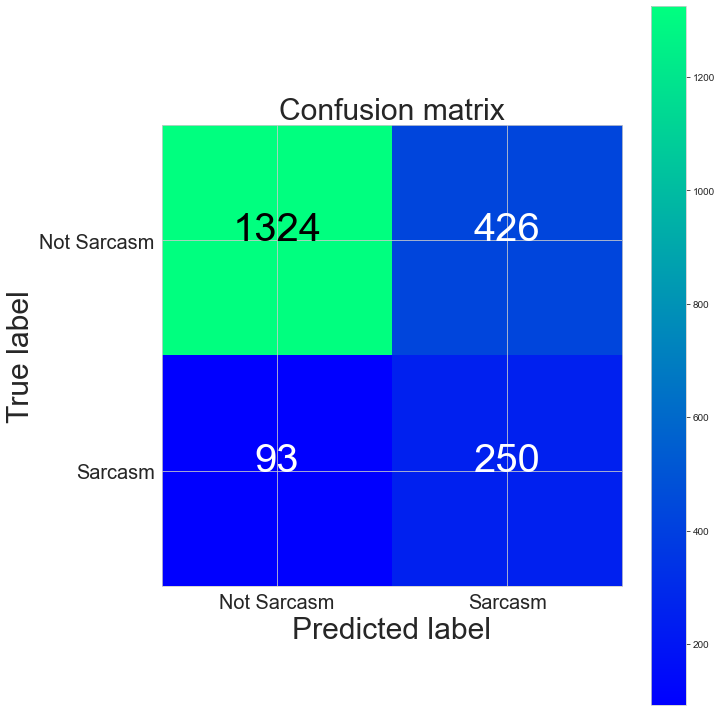

In [42]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_w2v.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

The f1 score for the testing data: 0.482573726541555
The precision score for the testing data: 0.3479381443298969
The recall score for the testing data: 0.7871720116618076
The accuracy score for the testing data: 0.7233635929288104


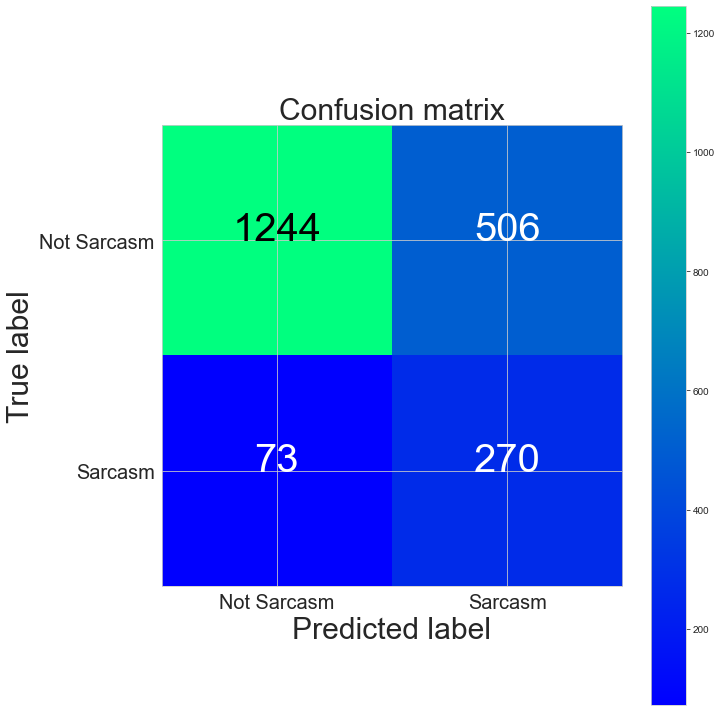

In [43]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
lr_w2v.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()

# Fitting Second Classifier (Support Vector Machine)

In [44]:
from sklearn.svm import SVC
svm = SVC(class_weight='balanced')
svm.fit(X_train_tfidf_emb, y_train)

# Predicting on the test data
pred_test = svm.predict(X_test_tfidf_emb)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)


The f1 score for the testing data: 0.37837837837837834
The precision score for the testing data: 0.56
The recall score for the testing data: 0.2857142857142857
The accuracy score for the testing data: 0.8461538461538461


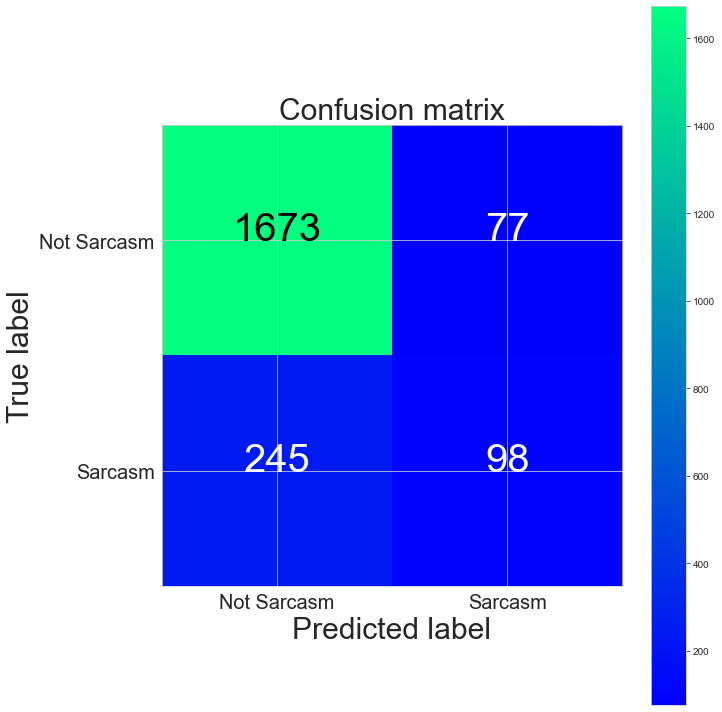

[[1673   77]
 [ 245   98]]


In [45]:
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

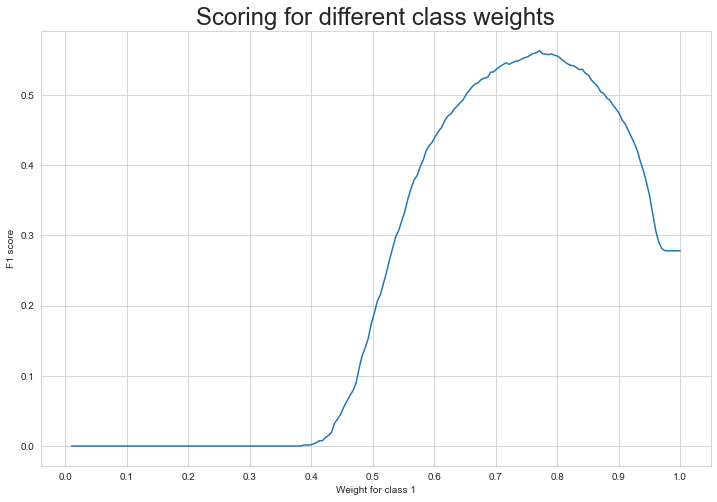

In [46]:
svm = SVC()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_embeddings,  y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [47]:
weight_for_high_score = weigh_data[weigh_data['score'] == np.max(weigh_data.score)]['weight']
weight_for_high_score

46    0.771156
Name: weight, dtype: float64

The f1 score for the testing data: 0.5105328376703842
The precision score for the testing data: 0.44396551724137934
The recall score for the testing data: 0.6005830903790087
The accuracy score for the testing data: 0.8112756808408982


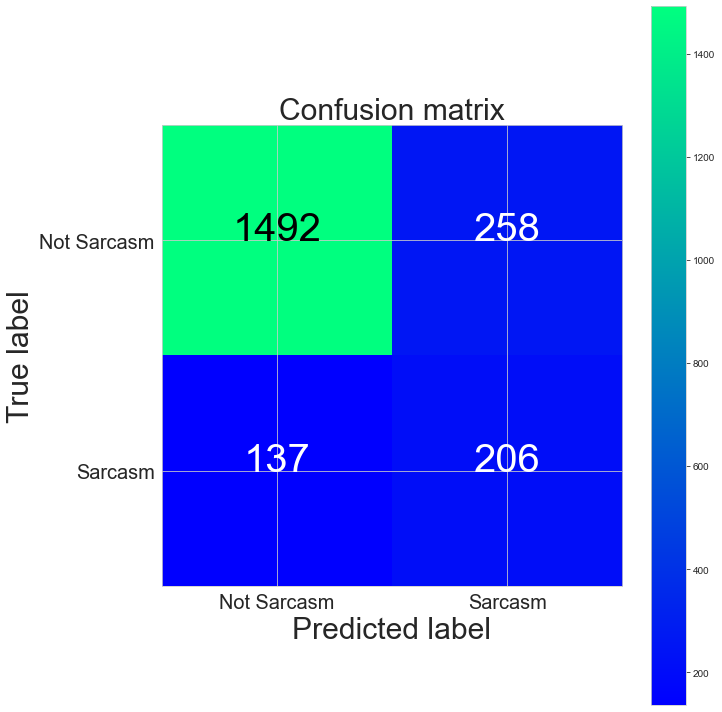

[[1492  258]
 [ 137  206]]


In [48]:
svm = SVC( class_weight={0: 1-weight_for_high_score, 1: weight_for_high_score})
svm.fit(train_embeddings, y_train)

# Predicting on the test data
pred_test = svm.predict(test_embeddings)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)
accuracy_test = accuracy_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)
print('The precision score for the testing data:', precision_test)
print('The recall score for the testing data:', recall_test)
print('The accuracy score for the testing data:', accuracy_test)

#Ploting the confusion matrix
cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not Sarcasm','Sarcasm'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

# Other

In [ ]:
def extract_emojis(tweet):
    return list(emojis.get(tweet))

In [ ]:
def contain_emoji(tweet):
    emo_list = list(emojis.get(tweet))
    if emo_list == list():
        return False
    else:
        return True

In [ ]:
df['emoji'] = df['tweet'].apply(extract_emojis)
df.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet,emoji
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح ما عمر اتنزل لعبة سوبر ماريو مش زي ما كان...,[]
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجلة ماري كلير ملك صحراء,"[❤️, 💭, 👑]"
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر,[]
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة أن دمشق صاير موسكو,[]
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد في حرس اعترف فقدان سيطرة أمني في شرقي و غ...,[]


In [ ]:
df['contain_emoji'] = df['tweet'].apply(contain_emoji)
df.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source,cleaned_tweet,emoji,contain_emoji
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval,نصيح ما عمر اتنزل لعبة سوبر ماريو مش زي ما كان...,[],False
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval,نادين نسيب نجيم مجلة ماري كلير ملك صحراء,"[❤️, 💭, 👑]",True
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval,أتوقع ان استمر,[],False
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval,عنى موافقة أن دمشق صاير موسكو,[],False
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval,قائد في حرس اعترف فقدان سيطرة أمني في شرقي و غ...,[],False
